In [43]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Sequential(nn.Linear(hidden_size, hidden_size),
                                nn.Dropout(),
                                nn.Linear(hidden_size,output_size))

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, (h1, c1) = self.lstm(x, (h0, c0))
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [44]:
import pandas as pd
file_path = './data/ETTm2.csv'
data = pd.read_csv(file_path)
data.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,41.130001,12.481,36.535999,9.355,4.424,1.311,38.661999
1,2016-07-01 00:15:00,39.622002,11.309,35.543999,8.551,3.209,1.258,38.223000
2,2016-07-01 00:30:00,38.868000,10.555,34.365002,7.586,4.435,1.258,37.344002
3,2016-07-01 00:45:00,35.518002,9.214,32.569000,8.712,4.435,1.215,37.124001
4,2016-07-01 01:00:00,37.528000,10.136,33.936001,7.532,4.435,1.215,37.124001


Text(0, 0.5, 'Oil Temperature')

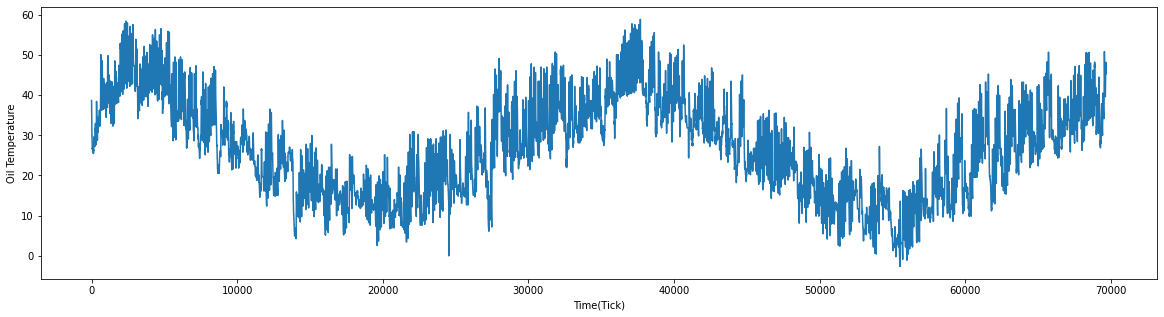

In [61]:
tick_interval = 30000
plt.figure(figsize=(20,5))
plt.plot(data.values[:,-1])
plt.xlabel("Time(Tick)")
plt.ylabel("Oil Temperature")
#x_labels = data.values[::tick_interval, 0].astype(str)


In [62]:
import numpy as np
import pywt
class LSTMDataSet(Dataset):
    def __init__(self, 
                 data, 
                 seq_len,
                 pred_len, 
                 train=True, 
                 test_size=0.2):
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.train = train
       
        if train:
            self.data_, _, = train_test_split(data, test_size=test_size,shuffle=False)
            data = self.data_.astype(np.float32)
            self.data = self.wavelet(data,wavelet_name='db4',threshold=0.5)
        else:
            _, self.data_ = train_test_split(data, test_size=test_size,shuffle=False)
            self.data_o = self.data_.astype(np.float32)
            self.data = self.wavelet(self.data_o,wavelet_name='db4',threshold=0.5)
        self.data_len = self.data.shape[0] - seq_len - pred_len - 1

    def __len__(self):
        return self.data_len

    def __getitem__(self, idx):
        X = self.data[idx:idx+self.seq_len,:]
        if self.train:
            y = self.data[idx+self.seq_len:idx+self.seq_len+self.pred_len,-1]
        else:
            y = self.data_o[idx+self.seq_len:idx+self.seq_len+self.pred_len,-1]
        return X, y
    def wavelet(self,data,wavelet_name='db4',threshold=0.5):
        coeffs = pywt.wavedec(data, wavelet_name)
        coeffs_thresholded = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
        reconstructed_signal = pywt.waverec(coeffs_thresholded, wavelet_name)
        return reconstructed_signal

In [64]:
trainset = LSTMDataSet(data=data.values[:,1:],seq_len=seq_len,pred_len=pred_len,train=True)
testset = LSTMDataSet(data=data.values[:,1:],seq_len=seq_len,pred_len=pred_len,train=False)

Text(0, 0.5, 'Oil Temperature')

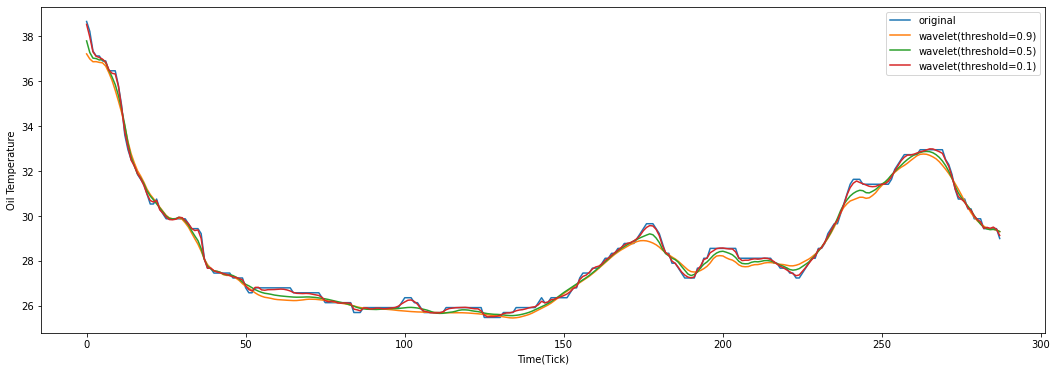

In [76]:
temp = data.values[:96*3,-1].astype(np.float32)
wavelet_temp = trainset.wavelet(temp,threshold=0.9)
wavelet_temp5 = trainset.wavelet(temp,threshold=0.5)
wavelet_temp1 = trainset.wavelet(temp,threshold=0.1)
plt.figure(figsize=(18,6))
plt.plot(temp)
plt.plot(wavelet_temp)
plt.plot(wavelet_temp5)
plt.plot(wavelet_temp1)
plt.legend(['original','wavelet(threshold=0.9)','wavelet(threshold=0.5)','wavelet(threshold=0.1)'])
plt.xlabel("Time(Tick)")
plt.ylabel("Oil Temperature")


In [63]:
# Example usage
input_size = 7  # Example input size
hidden_size = 100
batch_size = 1024
seq_len = 96
pred_len = 96
lr = 1e-4
num_epochs = 1_000

trainset = LSTMDataSet(data=data.values[:,1:],seq_len=seq_len,pred_len=pred_len,train=True)
testset = LSTMDataSet(data=data.values[:,1:],seq_len=seq_len,pred_len=pred_len,train=False)
trainloader = DataLoader(trainset,batch_size=batch_size,shuffle=False)
testloader = DataLoader(testset,batch_size=batch_size,shuffle=False)
output_size = pred_len  # Example output size

# Create a random input tensor
input_data = torch.randn(batch_size, seq_len, input_size)

# Create the model
model = LSTMModel(input_size, hidden_size, output_size)

# Forward pass
output = model(input_data)
print("Output shape:", output.shape)  # Expected output shape: (batch_size, output_size)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Output shape: torch.Size([1024, 96])


LSTMModel(
  (lstm): LSTM(7, 100, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=100, out_features=96, bias=True)
  )
)

In [41]:
try:
    checkpoint = torch.load('./wav_checkpoint2000.pth')
    print('load success')
    model.load_state_dict(checkpoint['state_dict'])
    #start_epoch = checkpoint['epoch']+1
    start_epoch = 2000
    train_log,test_log = np.zeros(start_epoch+num_epochs,),np.zeros(start_epoch+num_epochs,)
    train_log[:start_epoch] = checkpoint['train_log']
    test_log[:start_epoch] = checkpoint['test_log']
    
except:
    start_epoch = 0
    train_log,test_log = np.zeros(start_epoch+num_epochs,),np.zeros(start_epoch+num_epochs,)
    print('creat new')

load success
creat new


In [42]:
with tqdm(total=num_epochs) as pbar:
    pbar.update(0)
    for epoch in range(num_epochs):
        epoch_loss = 0
        model.train()
        for inputs_,targets_ in trainloader:
            inputs,targets = inputs_.to(device),targets_.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            batch_loss = loss.item()
            epoch_loss += batch_loss*inputs.size(0)
        epoch_loss /= trainset.__len__()
        model.eval()
        test_epoch_loss = 0
        for inputs_,targets_ in testloader:
            inputs,targets = inputs_.to(device),targets_.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            batch_loss = loss.item()
            test_epoch_loss += batch_loss*inputs.size(0)
        test_epoch_loss /= testset.__len__()
        train_log[start_epoch+epoch] = epoch_loss
        test_log[start_epoch+epoch] = test_epoch_loss
        pbar.set_postfix(train_loss=epoch_loss,test_loss=test_epoch_loss,epoch=start_epoch+epoch+1)
        pbar.update(1)
        

 47%|████▋     | 469/1000 [22:24<25:21,  2.87s/it, epoch=469, test_loss=21.6, train_loss=18.4]


KeyboardInterrupt: 

In [7]:
checkpoint = {
    'epoch': epoch,
    'state_dict': model.state_dict(),
    'train_log': train_log,
    'test_log':test_log}
torch.save(checkpoint, f"{pred_len}wav_checkpoint{start_epoch+epoch+1}.pth")

In [30]:
for inputs_,targets_ in trainloader:
    inputs,targets = inputs_.to(device),targets_.to(device)
    break

In [31]:
inputs.shape

torch.Size([1024, 96, 7])

In [32]:
outputs = model(inputs)
output.shape

torch.Size([1024, 32])

In [33]:
outputs = model(inputs)

In [34]:
inputs.shape,outputs.shape,targets.shape

(torch.Size([1024, 96, 7]), torch.Size([1024, 32]), torch.Size([1024, 32]))

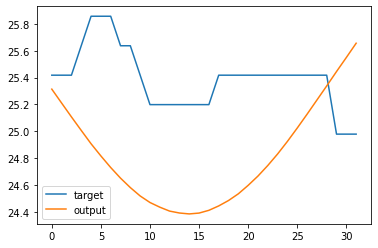

In [36]:
index = 0
plt.plot(targets.cpu()[index])
plt.plot(outputs.detach().cpu()[index])
plt.legend(['target', 'output'])

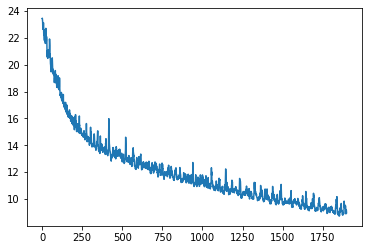

In [14]:
plt.plot(train_log[100:])

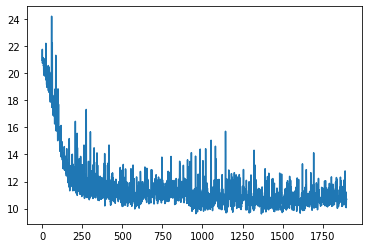

In [15]:
plt.plot(test_log[100:])